In [6]:
import os
import time

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

In [7]:
epochs = 50
number_of_examples = 16
batch_size = 16
latent_dim = 100
image_size = (64, 64) # h x w

seed = tf.random.normal([number_of_examples, latent_dim])

data_dir = r'../input/animal-faces/afhq/train/'

dataset = keras.preprocessing.image_dataset_from_directory(
    data_dir, label_mode=None, image_size=image_size, batch_size=batch_size
)

Found 0 files belonging to 1 classes.


ValueError: No images found.

In [8]:
dataset = dataset.map(lambda x: (x - 127.5) / 127.5) # Normalizing to -1,1

NameError: name 'dataset' is not defined

In [9]:
def add_upsampling_unit(model,
                        filters, kernel_size, strides, padding):
    model.add(
        keras.layers.Conv2DTranspose(
            filters=filters, kernel_size=kernel_size,
            strides=strides,
            padding=padding, activation="relu",
            kernel_initializer="he_normal"
        )
    )
    model.add(keras.layers.BatchNormalization())

def make_generator_model(latent_dim):
    model = keras.Sequential()
    model.add(keras.layers.Reshape((1, 1, 100), input_shape=[latent_dim]))

    add_upsampling_unit(model, 512, 4, (1, 1), 'valid')

    add_upsampling_unit(model, 256, 4, (2, 2), 'same')

    add_upsampling_unit(model, 128, 4, (2, 2), 'same')

    add_upsampling_unit(model, 64, 4, (2, 2), 'same')

    model.add(keras.layers.Conv2DTranspose(filters=3, kernel_size=4,
                                           strides=(2, 2), padding='same'))
    model.add(keras.layers.Activation("tanh"))

    return model

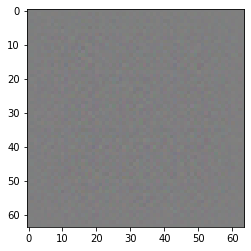

In [18]:
generator = make_generator_model(latent_dim)

noise = tf.random.normal([5, latent_dim])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0].numpy()*127.5+127.5).astype("uint32"))

In [30]:
def add_downsampling_unit(model, filters,
                          kernel_size, strides, padding):
    model.add(
        keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding, activation="relu",
            kernel_initializer="he_normal"
        )
    )
    model.add(keras.layers.BatchNormalization())

def make_discriminator_model():
    model = keras.Sequential()

    model.add(
        keras.layers.Conv2D(
            filters=64,
            kernel_size=4,
            strides=2,
            input_shape=(64, 64, 3),
            padding="same", activation="relu",
            kernel_initializer="he_normal"
        )
    )
    model.add(keras.layers.BatchNormalization())

    add_downsampling_unit(model, filters=128,
                          kernel_size=4, strides=2, padding="same")

    add_downsampling_unit(model, filters=256,
                          kernel_size=4, strides=2, padding="same")

    add_downsampling_unit(model, filters=512,
                          kernel_size=4, strides=2, padding="same")

    model.add(
        keras.layers.Conv2D(
            filters=100,
            kernel_size=4,
            strides=1,
            padding="valid",
            activation="relu"
        )
    )

    #model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))
    # model.add(Activation("sigmoid"))
    return model

In [31]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor(
[[[[-0.03751921]]]


 [[[-0.04314695]]]


 [[[-0.04623723]]]


 [[[-0.03216358]]]


 [[[-0.04129116]]]], shape=(5, 1, 1, 1), dtype=float32)


In [26]:
print(generator.summary())

print(discriminator.summary())



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 4, 4, 512)         819712    
_________________________________________________________________
batch_normalization_16 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 16, 128)      

In [17]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(4e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss,
        generator.trainable_variables
    )

    gradients_of_discriminator = disc_tape.gradient(
        disc_loss,
        discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator,
            generator.trainable_variables)
        )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator,
            discriminator.trainable_variables)
        )

    return (gen_loss, disc_loss)

In [ ]:
if not os.path.isdir("epochs"):
    os.mkdir("epochs")

def plot_grid_of_images(images, epoch):
    plt.figure(figsize=(8, 8))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((images[i].numpy() * 127.5 + 127.5).astype("uint32"))
        plt.axis('off')

    plt.savefig('epochs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
def train(dataset, epochs):
    generator_losses = np.empty((0, 0), dtype=float)
    discriminator_losses = np.empty((0, 0), dtype=float)
    for epoch in range(epochs):
        start = time.time()
        
        batch_generator_losses = np.empty((0, 0), dtype=float)
        batch_discriminator_losses = np.empty((0, 0), dtype=float)
        for (batch, image_batch) in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)
            
            if batch % 100 == 0:
                average_batch_loss =\
                   gen_loss.numpy()/int(image_batch.shape[1])
                print(f"""Epoch {epoch+1}
                        Batch {batch} Loss {average_batch_loss:.4f}""")

            batch_generator_losses = np.append(batch_generator_losses, gen_loss)
            batch_discriminator_losses = np.append(batch_discriminator_losses, disc_loss)
            
        if generator_losses.shape == (0, 0):
            generator_losses = batch_generator_losses
            discriminator_losses = batch_discriminator_losses
        else:
            generator_losses = np.vstack(
                [generator_losses, batch_generator_losses]
            )
            discriminator_losses = np.vstack(
                [discriminator_losses, batch_discriminator_losses]
            )
            
        # Saving the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        example_images = generator(seed, training=False)
        plot_grid_of_images(example_images, epoch)
        

    # Generating after the final epoch
    example_images = generator(seed, training=False)
    plot_grid_of_images(example_images, epoch)
    
    return (generator_losses, discriminator_losses)

In [ ]:
# Training the model
(generator_losses, discriminator_losses) = train(dataset, epochs)

In [ ]:
gen = generator_losses[:epochs].mean(axis=1) / batch_size
disc = discriminator_losses[:epochs].mean(axis=1) / batch_size

fig_1 = plt.figure(figsize=(8, 4), dpi=100)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('DCGAN hibaértékei az első 50 epoch alatt')
ax.plot(np.linspace(1, epochs, epochs), gen, label='Generator')
ax.plot(np.linspace(1, epochs, epochs), disc, label='Discriminator')
ax.legend(loc=0)

ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

x_ticks = np.arange(0, epochs+1, 5)
x_ticks[0] = 1
ax.set_xticks(x_ticks)
plt.show()